# Project 3: Multiclass and Linear Models

UIC CS 412, Spring 2018

_If you have discussed this assignment with anyone, please state their name(s) here: [NAMES]. Keep in mind the expectations set in the Academic Honesty part of the syllabus._

There are two parts to this project. The first is on multiclass reductions. The second is on linear models and gradient descent. There is also a third part which gives you an opportunity for extra credit.

This assignment is adapted from the github materials for [A Course in Machine Learning](https://github.com/hal3/ciml).

## Due Date

This assignment is due at 11:59pm Thursday, March 15th. 

### Files You'll Edit

``multiclass.py``: The multiclass classification implementation you need to complete.

``gd.py``: The gradient descent file you need to edit.

``quizbowl.py``: Multiclass evaluation of the quiz bowl dataset (optional).

``predictions.txt``: This file is automatically generated as part of Part 3 (optional).

### Files you might want to look at
  
``binary.py``: Our generic interface for binary classifiers (actually
works for regression and other types of classification, too).

``datasets.py``: Where a handful of test data sets are stored.

``util.py``: A handful of useful utility functions: these will
undoubtedly be helpful to you, so take a look!

``runClassifier.py``: A few wrappers for doing useful things with
classifiers, like training them, generating learning curves, etc.

``mlGraphics.py``: A few useful plotting commands

``data/*``: All of the datasets we'll use.

### What to Submit

You will hand in all of the python files listed above as a single zip file **h3.zip** on Gradescope under *Homework 3*.  The programming part constitutes 60% of the grade for this homework. You also need to answer the questions denoted by **WU#** (and a kitten) in this notebook which are the other 40% of your homework grade. When you are done, you should export **hw3.ipynb** with your answers as a PDF file **hw3WrittenPart.pdf**, upload the PDF file to Gradescope under *Homework 3 - Written Part*, and tag each question on Gradescope. 

Your entire homework will be considered late if any of these parts are submitted late. 

#### Autograding

Your code will be autograded for technical correctness. Please **do
not** change the names of any provided functions or classes within the
code, or you will wreak havoc on the autograder. We have provided two simple test cases that you can try your code on, see ``run_tests_simple.py``. As usual, you should create more test cases to make sure your code runs correctly.

# Part 1: Multiclass Classification *[30% impl, 20% writeup]*

In this section, you will explore the differences between three
multiclass-to-binary reductions: one-versus-all (OVA), all-versus-all
(AVA), and a tree-based reduction (TREE).  The evaluation will be on different datasets from 
`datasets.py`.

The classification task we'll work with is wine classification. The dataset was downloaded from allwines.com. Your job is to predict the type of wine, given the description of the wine. There are two tasks: WineData has 20 different wines, WineDataSmall is just the first five of those (sorted roughly by frequency). You can find the names of the wines both in WineData.labels as well as the file wines.names.

To start out, let's import everything and train decision "stumps" (aka depth=1 decision trees) on the large data set:

In [1]:
from sklearn.tree import DecisionTreeClassifier
import multiclass
import util
from datasets import *
import importlib
importlib.reload(multiclass)

h = multiclass.OVA(20, lambda: DecisionTreeClassifier(max_depth=1))
h.train(WineData.X, WineData.Y)
P = h.predictAll(WineData.Xte)
mean(P == WineData.Yte)
# 0.29499072356215211

training classifier for 0 versus rest
training classifier for 1 versus rest
training classifier for 2 versus rest
training classifier for 3 versus rest
training classifier for 4 versus rest
training classifier for 5 versus rest
training classifier for 6 versus rest
training classifier for 7 versus rest
training classifier for 8 versus rest
training classifier for 9 versus rest
training classifier for 10 versus rest
training classifier for 11 versus rest
training classifier for 12 versus rest
training classifier for 13 versus rest
training classifier for 14 versus rest
training classifier for 15 versus rest
training classifier for 16 versus rest
training classifier for 17 versus rest
training classifier for 18 versus rest
training classifier for 19 versus rest


0.29499072356215211

That means 29% accuracy on this task. The most frequent class is:

In [2]:
print(mode(WineData.Y))
# 1
print(WineData.labels[1])
# Cabernet-Sauvignon

1
Cabernet-Sauvignon


And if you were to always predict label 1, you would get the following accuracy:

In [3]:
mean(WineData.Yte == 1)
# 0.17254174397031541

0.17254174397031541

So we're doing a bit (12%) better than that using decision stumps. 

The default implementation of OVA uses decision tree confidence (probability of prediction) to weigh the votes. You can switch to zero/one predictions to see the effect:

In [4]:
P = h.predictAll(WineData.Xte, useZeroOne=True)
mean(P == WineData.Yte)
# 0.19109461966604824

0.19109461966604824

As you can see, this is markedly worse.

Switching to the smaller data set for a minute, we can train, say, depth 3 decision trees:

In [5]:
h = multiclass.OVA(5, lambda: DecisionTreeClassifier(max_depth=3))
h.train(WineDataSmall.X, WineDataSmall.Y)
P = h.predictAll(WineDataSmall.Xte)
print(mean(P == WineDataSmall.Yte))
# 0.590809628009
print(mean(WineDataSmall.Yte == 1))
# 0.407002188184

training classifier for 0 versus rest
training classifier for 1 versus rest
training classifier for 2 versus rest
training classifier for 3 versus rest
training classifier for 4 versus rest
0.606126914661
0.407002188184


So using depth 3 trees we get an accuracy of about 60% (this number varies a bit), versus a baseline of 41%. That's not too terrible, but not great.

We can look at what this classifier is doing.

In [6]:
print(WineDataSmall.labels[0])
#'Sauvignon-Blanc'
util.showTree(h.f[0], WineDataSmall.words)
#citrus?
#-N-> lime?
#|    -N-> gooseberry?
#|    |    -N-> class 0	(356.0 for class 0, 10.0 for class 1)
#|    |    -Y-> class 1	(0.0 for class 0, 4.0 for class 1)
#|    -Y-> apple?
#|    |    -N-> class 1	(1.0 for class 0, 15.0 for class 1)
#|    |    -Y-> class 0	(2.0 for class 0, 0.0 for class 1)
#-Y-> grapefruit?
#|    -N-> flavors?
#|    |    -N-> class 1	(4.0 for class 0, 12.0 for class 1)
#|    |    -Y-> class 0	(11.0 for class 0, 5.0 for class 1)
#|    -Y-> opens?
#|    |    -N-> class 1	(0.0 for class 0, 14.0 for class 1)
#|    |    -Y-> class 0	(1.0 for class 0, 0.0 for class 1)

Sauvignon-Blanc
citrus?
-N-> lime?
|    -N-> gooseberry?
|    |    -N-> class 0	(356.0 for class 0, 10.0 for class 1)
|    |    -Y-> class 1	(0.0 for class 0, 4.0 for class 1)
|    -Y-> apple?
|    |    -N-> class 1	(1.0 for class 0, 15.0 for class 1)
|    |    -Y-> class 0	(2.0 for class 0, 0.0 for class 1)
-Y-> grapefruit?
|    -N-> flavors?
|    |    -N-> class 1	(4.0 for class 0, 12.0 for class 1)
|    |    -Y-> class 0	(11.0 for class 0, 5.0 for class 1)
|    -Y-> opens?
|    |    -N-> class 1	(0.0 for class 0, 14.0 for class 1)
|    |    -Y-> class 0	(1.0 for class 0, 0.0 for class 1)


This should show the tree that's associated with predicting label 0 (which is stored in h.f[0]). The 1s mean "likely to be Sauvignon-Blanc" and the 0s mean "likely not to be".

Now, go in and complete the AVA implementation in `multiclass.py`. You should be able to train an AVA model on the small data set by:

In [7]:
import importlib
importlib.reload(multiclass)

h = multiclass.AVA(5, lambda: DecisionTreeClassifier(max_depth=3))
h.train(WineDataSmall.X, WineDataSmall.Y)
P = h.predictAll(WineDataSmall.Xte)

training classifier for 1 versus 0
training classifier for 2 versus 0
training classifier for 2 versus 1
training classifier for 3 versus 0
training classifier for 3 versus 1
training classifier for 3 versus 2
training classifier for 4 versus 0
training classifier for 4 versus 1
training classifier for 4 versus 2
training classifier for 4 versus 3


Next, you must implement a 
tree-based reduction in `multiclass.py`. Most of train is given to you, but predict you
must do all on your own. There is a tree class to help you:

In [8]:
t = multiclass.makeBalancedTree(range(5))
print(t)
# [[0 1]] [2 [3 4]]]
print(t.isLeaf)
# False
print(t.getRight())
# [2 [3 4]]
print(t.getRight().getLeft())
# 2
print(t.getRight().getLeft().isLeaf)
# True

[[0 1] [2 [3 4]]]
False
[2 [3 4]]
2
True


You should be able to train a MCTree model by:

In [10]:
importlib.reload(multiclass)
h = multiclass.MCTree(t, lambda: DecisionTreeClassifier(max_depth=3))
h.train(WineDataSmall.X, WineDataSmall.Y)
P = h.predictAll(WineDataSmall.Xte)
print(mean(P == WineDataSmall.Yte))
print(mean(1 == WineDataSmall.Yte))

training classifier for [0, 1] versus [2, 3, 4]
training classifier for [0] versus [1]
training classifier for [2] versus [3, 4]
training classifier for [3] versus [4]
0.562363238512
0.407002188184


In [11]:
importlib.reload(multiclass)
t = multiclass.makeBalancedTree(range(20))
h = multiclass.MCTree(t, lambda: DecisionTreeClassifier(max_depth=3))
h.train(WineData.X, WineData.Y)
P = h.predictAll(WineData.Xte)
print(mean(P == WineData.Yte))
print(mean(1 == WineData.Yte))

training classifier for [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] versus [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
training classifier for [0, 1, 2, 3, 4] versus [5, 6, 7, 8, 9]
training classifier for [0, 1] versus [2, 3, 4]
training classifier for [0] versus [1]
training classifier for [2] versus [3, 4]
training classifier for [3] versus [4]
training classifier for [5, 6] versus [7, 8, 9]
training classifier for [5] versus [6]
training classifier for [7] versus [8, 9]
training classifier for [8] versus [9]
training classifier for [10, 11, 12, 13, 14] versus [15, 16, 17, 18, 19]
training classifier for [10, 11] versus [12, 13, 14]
training classifier for [10] versus [11]
training classifier for [12] versus [13, 14]
training classifier for [13] versus [14]
training classifier for [15, 16] versus [17, 18, 19]
training classifier for [15] versus [16]
training classifier for [17] versus [18, 19]
training classifier for [18] versus [19]
0.308905380334
0.17254174397


<img src="data/kitten.jpeg" width="100px" align="left" float="left"/>
<br><br><br>
## WU1 (10%):
Answer A, B, C for both OVA and AVA.

(A) What words are most indicative of being Sauvignon-Blanc? Which words are most indicative of not being Sauvignon-Blanc? What about Pinot-Noir (label==2)?

(B) Train depth 3 decision trees on the full WineData task (with 20 labels). What accuracy do you get? How long does this take (in seconds)? One of my least favorite wines is Viognier -- what words are indicative of this?

(C) Compare the accuracy using zero-one predictions versus using confidence. How much difference does it make?

In [12]:
#(A) What words are most indicative of being Sauvignon-Blanc? 
#Which words are most indicative of not being Sauvignon-Blanc? What about Pinot-Noir (label==2)?

# ********* OVA Training **********

h = multiclass.OVA(5, lambda: DecisionTreeClassifier(max_depth=3))
h.train(WineDataSmall.X, WineDataSmall.Y)
P = h.predictAll(WineDataSmall.Xte)
print(mean(P == WineDataSmall.Yte))
print("")
print("*********** OVA Classifiers' trees ***********")
print("")
print(WineDataSmall.labels[0])
util.showTree(h.f[0], WineDataSmall.words)
print("")

print(WineDataSmall.labels[1])
util.showTree(h.f[1], WineDataSmall.words)
print("")

print(WineDataSmall.labels[2])
util.showTree(h.f[2], WineDataSmall.words)
print("")

print(WineDataSmall.labels[3])
util.showTree(h.f[3], WineDataSmall.words)
print("")

print(WineDataSmall.labels[4])
util.showTree(h.f[4], WineDataSmall.words)
print("")

# ********* AVA Training **********

h = multiclass.AVA(5, lambda: DecisionTreeClassifier(max_depth=3))
h.train(WineDataSmall.X, WineDataSmall.Y)
P = h.predictAll(WineDataSmall.Xte)
print(mean(P == WineDataSmall.Yte))
print("")
print("*********** AVA Classifiers' trees ***********")
print("")
util.showTree(h.f[4][3], WineDataSmall.words)
print("")
util.showTree(h.f[4][2], WineDataSmall.words)
print("")
util.showTree(h.f[4][1], WineDataSmall.words)
print("")
util.showTree(h.f[4][0], WineDataSmall.words)
print("")
util.showTree(h.f[3][2], WineDataSmall.words)
print("")
util.showTree(h.f[3][1], WineDataSmall.words)
print("")
util.showTree(h.f[3][0], WineDataSmall.words)
print("")
util.showTree(h.f[2][1], WineDataSmall.words)
print("")
util.showTree(h.f[2][0], WineDataSmall.words)
print("")
util.showTree(h.f[1][0], WineDataSmall.words)
print("")

training classifier for 0 versus rest
training classifier for 1 versus rest
training classifier for 2 versus rest
training classifier for 3 versus rest
training classifier for 4 versus rest
0.599562363239

*********** OVA Classifiers' trees ***********

Sauvignon-Blanc
citrus?
-N-> lime?
|    -N-> gooseberry?
|    |    -N-> class 0	(356.0 for class 0, 10.0 for class 1)
|    |    -Y-> class 1	(0.0 for class 0, 4.0 for class 1)
|    -Y-> hint?
|    |    -N-> class 1	(1.0 for class 0, 15.0 for class 1)
|    |    -Y-> class 0	(2.0 for class 0, 0.0 for class 1)
-Y-> grapefruit?
|    -N-> flavors?
|    |    -N-> class 1	(4.0 for class 0, 12.0 for class 1)
|    |    -Y-> class 0	(11.0 for class 0, 5.0 for class 1)
|    -Y-> stone?
|    |    -N-> class 1	(0.0 for class 0, 14.0 for class 1)
|    |    -Y-> class 0	(1.0 for class 0, 0.0 for class 1)

Cabernet-Sauvignon
tannins?
-N-> blackberry?
|    -N-> black?
|    |    -N-> class 0	(173.0 for class 0, 30.0 for class 1)
|    |    -Y-> class 1	(2

.

In [13]:
#(B) Train depth 3 decision trees on the full WineData task (with 20 labels). 
#What accuracy do you get? How long does this take (in seconds)? 
#One of my least favorite wines is Viognier -- what words are indicative of this?

import time

print("Training depth 3 decision trees on the full WineData task (with 20 labels) for OVA")
start_time = time.time()
ova = multiclass.OVA(20, lambda: DecisionTreeClassifier(max_depth=3))
ova.train(WineData.X, WineData.Y)
P = ova.predictAll(WineData.Xte)
end_time = time.time()
print("")
print("OVA Accuracy on the full WineData task with 20 labels:",mean(P == WineData.Yte))
print("Label 1 prediction accuracy:",mean(1 == WineData.Yte))
print("Execution time for OVA:",end_time - start_time)
print("")
# ******Label Wine Viognier******
print(WineData.labels[17])
util.showTree(ova.f[17], WineData.words)


print("")
print("Training depth 3 decision trees on the full WineData task (with 20 labels) for AVA")
start_time = time.time()
ava = multiclass.AVA(20, lambda: DecisionTreeClassifier(max_depth=3))
ava.train(WineData.X, WineData.Y)
P = ava.predictAll(WineData.Xte)
end_time = time.time()
print("AVA Accuracy on the full WineData task with 20 labels:",mean(P == WineData.Yte))
print("Label 1 prediction accuracy:",mean(1 == WineData.Yte))
print("Execution time for AVA:",end_time - start_time)
print("")
# ****** Viognier******
print(WineData.labels[17])
util.showTree(ava.f[17][0], WineData.words)
print("")
util.showTree(ava.f[17][1], WineData.words)
print("")
util.showTree(ava.f[17][2], WineData.words)
print("")
util.showTree(ava.f[17][3], WineData.words)
print("")
util.showTree(ava.f[17][4], WineData.words)
print("")
util.showTree(ava.f[17][5], WineData.words)
print("")
util.showTree(ava.f[17][6], WineData.words)
print("")
util.showTree(ava.f[17][7], WineData.words)
print("")
util.showTree(ava.f[17][8], WineData.words)
print("")
util.showTree(ava.f[17][9], WineData.words)
print("")
util.showTree(ava.f[17][10], WineData.words)
print("")
util.showTree(ava.f[17][11], WineData.words)
print("")
util.showTree(ava.f[17][12], WineData.words)
print("")
util.showTree(ava.f[17][13], WineData.words)
print("")
util.showTree(ava.f[17][14], WineData.words)
print("")
util.showTree(ava.f[17][15], WineData.words)
print("")
util.showTree(ava.f[17][16], WineData.words)
print("")
util.showTree(ava.f[18][17], WineData.words)
print("")
util.showTree(ava.f[19][17], WineData.words)
print("")

Training depth 3 decision trees on the full WineData task (with 20 labels) for OVA
training classifier for 0 versus rest
training classifier for 1 versus rest
training classifier for 2 versus rest
training classifier for 3 versus rest
training classifier for 4 versus rest
training classifier for 5 versus rest
training classifier for 6 versus rest
training classifier for 7 versus rest
training classifier for 8 versus rest
training classifier for 9 versus rest
training classifier for 10 versus rest
training classifier for 11 versus rest
training classifier for 12 versus rest
training classifier for 13 versus rest
training classifier for 14 versus rest
training classifier for 15 versus rest
training classifier for 16 versus rest
training classifier for 17 versus rest
training classifier for 18 versus rest
training classifier for 19 versus rest

OVA Accuracy on the full WineData task with 20 labels: 0.37012987013
Label 1 prediction accuracy: 0.17254174397
Execution time for OVA: 2.45550251

AVA Accuracy on the full WineData task with 20 labels: 0.0593692022263
Label 1 prediction accuracy: 0.17254174397
Execution time for AVA: 14.578674077987671

Viognier
floral?
-N-> harmonious?
|    -N-> signature?
|    |    -N-> class 0	(59.0 for class 0, 2.0 for class 1)
|    |    -Y-> class 1	(0.0 for class 0, 1.0 for class 1)
|    -Y-> class 1	(0.0 for class 0, 1.0 for class 1)
-Y-> finish?
|    -N-> class 1	(0.0 for class 0, 4.0 for class 1)
|    -Y-> class 0	(1.0 for class 0, 0.0 for class 1)

peach?
-N-> peaches?
|    -N-> pear?
|    |    -N-> class 0	(187.0 for class 0, 0.0 for class 1)
|    |    -Y-> class 1	(0.0 for class 0, 1.0 for class 1)
|    -Y-> class 1	(0.0 for class 0, 3.0 for class 1)
-Y-> class 1	(0.0 for class 0, 4.0 for class 1)

peaches?
-N-> peach?
|    -N-> apple?
|    |    -N-> class 0	(144.0 for class 0, 0.0 for class 1)
|    |    -Y-> class 1	(0.0 for class 0, 1.0 for class 1)
|    -Y-> class 1	(0.0 for class 0, 3.0 for class 1)
-Y-> class 1	(0.0 for class 0, 

In [14]:
# (C) Compare the accuracy using zero-one predictions versus using confidence. How much difference does it make?

ova = multiclass.OVA(20, lambda: DecisionTreeClassifier(max_depth=3))
ova.train(WineData.X, WineData.Y)
P_confidence = ova.predictAll(WineData.Xte)  #by default useZeroOne=False
accuracy_confidence = mean(P_confidence == WineData.Yte)
print("")
print("OVA Accuracy using confidence: ",accuracy_confidence)

print("")
P_zero_one = ova.predictAll(WineData.Xte, useZeroOne=True)
accuracy_zero_one = mean(P_zero_one == WineData.Yte)
print("OVA Accuracy using zero-one predictions: ",accuracy_zero_one)
print("")
print("OVA Accuracy difference on switching from confidence to zero-one predictions:",accuracy_zero_one - accuracy_confidence)
print("")
ava = multiclass.AVA(20, lambda: DecisionTreeClassifier(max_depth=3))
ava.train(WineData.X, WineData.Y)
P_confidence = ava.predictAll(WineData.Xte)  #by default useZeroOne=False
print("")
accuracy_confidence = mean(P_confidence == WineData.Yte)
print("AVA Accuracy using confidence: ",accuracy_confidence)

print("")
P_zero_one = ova.predictAll(WineData.Xte, useZeroOne=True)
accuracy_zero_one = mean(P_zero_one == WineData.Yte)
print("AVA Accuracy using zero-one predictions: ",accuracy_zero_one)
print("")
print("AVA Accuracy difference on switching from confidence to zero-one predictions:",accuracy_zero_one - accuracy_confidence)

training classifier for 0 versus rest
training classifier for 1 versus rest
training classifier for 2 versus rest
training classifier for 3 versus rest
training classifier for 4 versus rest
training classifier for 5 versus rest
training classifier for 6 versus rest
training classifier for 7 versus rest
training classifier for 8 versus rest
training classifier for 9 versus rest
training classifier for 10 versus rest
training classifier for 11 versus rest
training classifier for 12 versus rest
training classifier for 13 versus rest
training classifier for 14 versus rest
training classifier for 15 versus rest
training classifier for 16 versus rest
training classifier for 17 versus rest
training classifier for 18 versus rest
training classifier for 19 versus rest

OVA Accuracy using confidence:  0.373840445269

OVA Accuracy using zero-one predictions:  0.251391465677

OVA Accuracy difference on switching from confidence to zero-one predictions: -0.122448979592

training classifier for 1 ve

[WU1 Answer] : 

(A) What words are most indicative of being Sauvignon-Blanc? Which words are most indicative of not being Sauvignon-Blanc? What about Pinot-Noir (label==2)?

Citrus, Lime and Gooseberry are the most indicative words of not being Sauvignon-Blanc as these combinations predicts 356 actual non Sauvignon-Blanc wine as not being Sauvignon-Blanc which is a huge number and only 10 actual Sauvignon-Blanc wine as not being Sauvignon-Blanc.

Citrus, Grapefruit and opens are the most indicative words of being Sauvignon-Blanc as these combinations predicts 14 actual  Sauvignon-Blanc wine as being Sauvignon-Blanc and 0 actual non Sauvignon-Blanc wine as being Sauvignon-Blanc.

Cherry, Raspberries and Strawberries are the most indicative words of not being Pinot-Noir as these combination of words predicts 225 actual non Pinot-Noir as not being Pinot Noir which is a huge number.

Cherry, Raspberries and round are the most indicative words of being Pinot-Noir as these combination of words predicts 12 actual  Pinot-Noir as being Pinot Noir and 0 actual non Pinot-Noir as Pinot-Noir.


(B) Train depth 3 decision trees on the full WineData task (with 20 labels). What accuracy do you get? How long does this take (in seconds)? One of my least favorite wines is Viognier -- what words are indicative of this?

OVA Accuracy on the full WineData task with 20 labels: 0.369202226345
Execution time for OVA: 2.4106128215789795
AVA Accuracy on the full WineData task with 20 labels: 0.0556586270872
Execution time for AVA: 13.042717933654785

peaches, nectarine and chilled are the most indicative words of not being Viognier wine as these combinations predicts 1036 actual non Viognier wine as not being Viognier wine which is very huge number to make these words indicative for this wine.

peaches and milk are the most indicative words of being Viognier wine as these combinations predicts 3 actual Viognier wine as being Viognier wine and 0 non Viognier as being Viognier wine.

(C) Compare the accuracy using zero-one predictions versus using confidence. How much difference does it make?

OVA Accuracy is getting decreased by 0.12 on using zero-one prediction instead of confidence. But AVA accuracy got increased by 0.18 on using zero-one prediction instead of confidence.

<img src="data/kitten.jpeg" width="100px" align="left" float="left"/>
<br><br><br>
## WU2 (10%):
Using decision trees of constant depth for each
classifier (but you choose it as well as you can!), train AVA, OVA and
Tree (using balanced trees) for the wine data. Which does best and why?

In [15]:
# WU2 CODE HERE
ova = multiclass.OVA(20, lambda: DecisionTreeClassifier(max_depth=6))
ova.train(WineData.X, WineData.Y)
P = ova.predictAll(WineData.Xte)  
accuracy = mean(P == WineData.Yte)
print("")
print("OVA Accuracy using max_depth 6: ",accuracy)

print("")
ava = multiclass.AVA(20, lambda: DecisionTreeClassifier(max_depth=6))
ava.train(WineData.X, WineData.Y)
P = ava.predictAll(WineData.Xte)  
print("")
accuracy = mean(P == WineData.Yte)
print("AVA Accuracy using max_depth 6: ",accuracy)

h = multiclass.MCTree(t, lambda: DecisionTreeClassifier(max_depth=6))
h.train(WineData.X, WineData.Y)
P = h.predictAll(WineData.Xte)
print("")
accuracy = mean(P == WineData.Yte)
print("Tree Accuracy using max_depth 6: ",accuracy)


training classifier for 0 versus rest
training classifier for 1 versus rest
training classifier for 2 versus rest
training classifier for 3 versus rest
training classifier for 4 versus rest
training classifier for 5 versus rest
training classifier for 6 versus rest
training classifier for 7 versus rest
training classifier for 8 versus rest
training classifier for 9 versus rest
training classifier for 10 versus rest
training classifier for 11 versus rest
training classifier for 12 versus rest
training classifier for 13 versus rest
training classifier for 14 versus rest
training classifier for 15 versus rest
training classifier for 16 versus rest
training classifier for 17 versus rest
training classifier for 18 versus rest
training classifier for 19 versus rest

OVA Accuracy using max_depth 6:  0.364564007421

training classifier for 1 versus 0
training classifier for 2 versus 0
training classifier for 2 versus 1
training classifier for 3 versus 0
training classifier for 3 versus 1
train


Tree Accuracy using max_depth 6:  0.30241187384


[WU2 ANSWER HERE] 
Using decision trees of constant depth for each classifier (but you choose it as well as you can!), train AVA, OVA and Tree (using balanced trees) for the wine data. Which does best and why?

OVA Accuracy using max_depth 4:  0.349721706865
OVA Accuracy using max_depth 5:  0.356215213358
OVA Accuracy using max_depth 6:  0.360853432282
OVA Accuracy using max_depth 7:  0.34879406308

AVA Accuracy using max_depth 4:  0.0677179962894
AVA Accuracy using max_depth 5:  0.0621521335807
AVA Accuracy using max_depth 6:  0.0640074211503
AVA Accuracy using max_depth 7:  0.0658627087199

Tree Accuracy using max_depth 4:  0.233766233766
Tree Accuracy using max_depth 5:  0.237476808905
Tree Accuracy using max_depth 6:  0.233766233766
Tree Accuracy using max_depth 7:  0.23654

On training OVA, AVA and Tree (using balanced trees) for the wine data for different depths, we can see that OVA is doing better as compared to AVA and Tree and with decision tree of depth 6, its accuracy is highest that is 0.360853432282. Hence OVA does best for this classification problem over winedata. 

The best multiclass classification method to use when generalizing binary to multiclass is highly specific to the problem. Since our wine dataset is small having only 2156 smaples and to train the model better, we need good amount of data. Thus OVA will do better in this case. In OVA, we use the entire dataset to build each OVA classifier. To build each ith OVA classifier, training examples corresponding to class i is considered as positive and rest all examples are considered as negative and on this we run binary classifier, hence using entire dataset for each classifier to train the model better. But in case of AVA and Tree, we use only subset of dataset to build each classifier. Since our dataset is small, we should use as much of data as we can to train our model to get best accuracy and OVA does this for given problem and dataset.

<img src="data/kitten.jpeg" width="100px" align="left" float="left"/>
<br><br><br>
## WU-EC1 ExtraCredit (10%):
Build a better tree (any way you want) other
than the balanced binary tree. Fill in your code for this in
`getMyTreeForWine`, which defaults to a balanced tree. It should get
at least 5% lower absolute error to get the extra credit. Describe what you
did.

[YOUR WU-EC1 ANSWER HERE] 
To build a better tree for more accuracy as compared to balanced binary tree, I changed the splitting of the tree from as in balanced binary tree. In my implementation, at each node I am splitting the tree as first item in left tree and rest in right tree and so on. This implementation gives 5% lower absolute error which is shown below in execution of the both trees.

In [16]:
importlib.reload(multiclass)

balanced_tree = multiclass.makeBalancedTree(range(15))
print("*********Balanced Tree***********")
print(balanced_tree)
print("")
h = multiclass.MCTree(balanced_tree, lambda: DecisionTreeClassifier(max_depth=3))
h.train(WineData.X, WineData.Y)
P = h.predictAll(WineData.Xte)
print("Accuracy with balanced tree: ",mean(P == WineData.Yte))
print("")
my_tree = multiclass.getMyTreeForWine(range(15))
print("*********My Tree***********")
print(my_tree)
print("")
h = multiclass.MCTree(my_tree, lambda: DecisionTreeClassifier(max_depth=3))
h.train(WineData.X, WineData.Y)
P = h.predictAll(WineData.Xte)
print("Accuracy with my tree: ",mean(P == WineData.Yte))

*********Balanced Tree***********
[[[0 [1 2]] [[3 4] [5 6]]] [[[7 8] [9 10]] [[11 12] [13 14]]]]

training classifier for [0, 1, 2, 3, 4, 5, 6] versus [7, 8, 9, 10, 11, 12, 13, 14]
training classifier for [0, 1, 2] versus [3, 4, 5, 6]
training classifier for [0] versus [1, 2]
training classifier for [1] versus [2]
training classifier for [3, 4] versus [5, 6]
training classifier for [3] versus [4]
training classifier for [5] versus [6]
training classifier for [7, 8, 9, 10] versus [11, 12, 13, 14]
training classifier for [7, 8] versus [9, 10]
training classifier for [7] versus [8]
training classifier for [9] versus [10]
training classifier for [11, 12] versus [13, 14]
training classifier for [11] versus [12]
training classifier for [13] versus [14]
Accuracy with balanced tree:  0.272727272727

*********My Tree***********
[[[[[[[0 [1 2]] [3 4]] [5 6]] [7 8]] [9 10]] [11 12]] [13 14]]

training classifier for [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] versus [13, 14]
training classifier fo

# Part 2: Gradient Descent and Linear Classification *[30% impl, 20% writeup]*

To get started with linear models, we will implement a generic
gradient descent method.  This should go in `gd.py`, which
contains a single (short) function: `gd`. This takes five
parameters: the function we're optimizing, it's gradient, an initial
position, a number of iterations to run, and an initial step size.

In each iteration of gradient descent, we will compute the gradient
and take a step in that direction, with step size `eta`.  We
will have an *adaptive* step size, where `eta` is computed
as `stepSize` divided by the square root of the iteration
number (counting from one).

Once you have an implementation running, we can check it on a simple
example of minimizing the function `x^2`:

In [2]:
import imports
from numpy import *
from pylab import *
from util import *
import datasets,binary,gd,linear,mlGraphics,multiclass,runClassifier
import importlib
importlib.reload(linear)
importlib.reload(gd)

gd.gd(lambda x: x**2, lambda x: 2*x, 10, 10, 0.2)
#(1.0034641051795872, array([ 100.        ,   36.        ,   18.5153247 ,   10.95094653,
#          7.00860578,    4.72540613,    3.30810578,    2.38344246,
#          1.75697198,    1.31968118,    1.00694021]))

(1.0034641051795872,
 array([ 100.        ,   36.        ,   18.5153247 ,   10.95094653,
           7.00860578,    4.72540613,    3.30810578,    2.38344246,
           1.75697198,    1.31968118,    1.00694021]))

You can see that the "solution" found is about 1, which is not great
(it should be zero!), but it's better than the initial value of ten!
If yours is going up rather than going down, you probably have a sign
error somewhere!

We can let it run longer and plot the trajectory:

0.003645900464603937


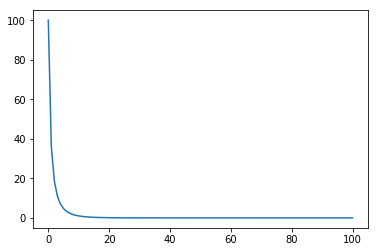

In [18]:
#Step size = 0.2
x, trajectory = gd.gd(lambda x: x**2, lambda x: 2*x, 10, 100, 0.2)
print(x)
# 0.003645900464603937
plot(trajectory)
show(True)

0.21734427526984595


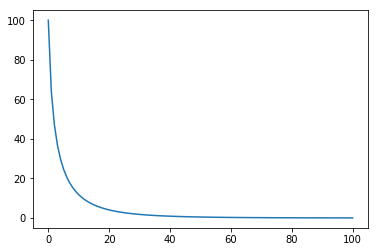

In [19]:
#Step size = 0.1
x, trajectory = gd.gd(lambda x: x**2, lambda x: 2*x, 10, 100, 0.1)
print(x)
plot(trajectory)
show(True)

0.0


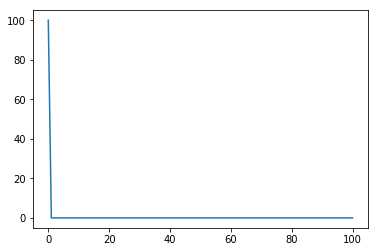

In [20]:
#Step size = 0.5
x, trajectory = gd.gd(lambda x: x**2, lambda x: 2*x, 10, 100, 0.5)
print(x)
plot(trajectory)
show(True)

0.0


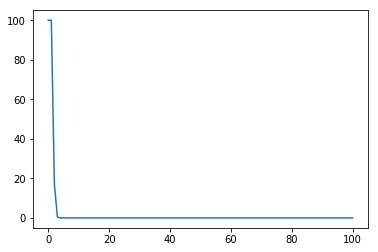

In [21]:
#Step size = 1
x, trajectory = gd.gd(lambda x: x**2, lambda x: 2*x, 10, 100, 1)
print(x)
plot(trajectory)
show(True)

1.0570252338952513e-21


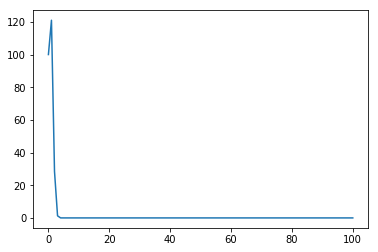

In [22]:
#Step size = 1.05
x, trajectory = gd.gd(lambda x: x**2, lambda x: 2*x, 10, 100, 1.05)
print(x)
plot(trajectory)
show(True)

3.970721293692096e-23


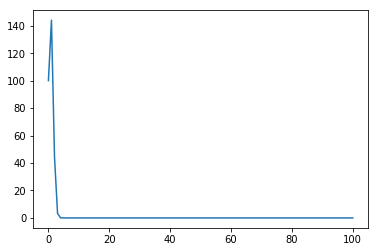

In [23]:
#Step size = 1.1
x, trajectory = gd.gd(lambda x: x**2, lambda x: 2*x, 10, 100, 1.1)
print(x)
plot(trajectory)
show(True)

9.107243088758273e-11


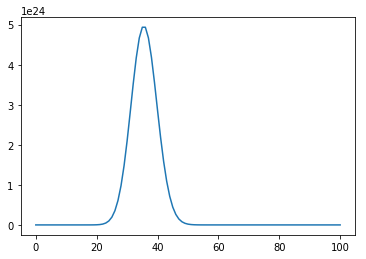

In [24]:
#Step size = 5
x, trajectory = gd.gd(lambda x: x**2, lambda x: 2*x, 10, 100, 6)
print(x)
plot(trajectory)
show(True)

# It's now found a value close to zero and you can see that the
objective is decreasing by looking at the plot.

<img src="data/kitten.jpeg" width="100px" align="left" float="left"/>
<br><br><br>
## WU3 (5%):
Find a few values of step size where it converges and
a few values where it diverges.  Where does the threshold seem to
be?

[WU3 Answer: As from the above graphs with different step size values, it can be inferred that if step size is less than or equal to 1 the objective decreases continuously i.e; we get pure convergence. But on increasing the step size value from 1, in the start objective increases and then decreases. So step size more than 1 introduces divergence as we can see in the graph of step sizes 1.05 and 1.1. 
So, few values of step size where it converges can be 0.2, 0.3, 0.4, 0.5 and few values of step size where it diverges can be 1.1, 1.2, 4, 6. And step size = 1  would become threshold here, step size more than this introduces divergence.]

<img src="data/kitten.jpeg" width="100px" align="left" float="left"/>
<br><br><br>
## WU4 (10%):
Come up with a *non-convex* univariate
optimization problem.  Plot the function you're trying to minimize and
show two runs of `gd`, one where it gets caught in a local
minimum and one where it manages to make it to a global minimum.  (Use
different starting points to accomplish this.)

If you implemented it well, this should work in multiple dimensions,
too:

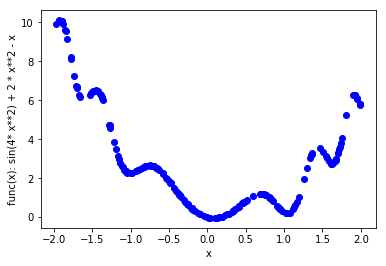

In [25]:
def generate_random_numbers_in_range(n, r_start, r_end):
    random_numbers = list()
    for i in range(n):
        random_numbers.append(random.uniform(r_start, r_end))
    return random_numbers

X = generate_random_numbers_in_range(200, -2, 2) 

import numpy as np
import math
import matplotlib.pylab as pylab

f = lambda x: sin(4* x**2) + 2 * x**2 - x
Y = []
for i in range(len(X)): 
    Y.append(f(X[i]))

pylab.xlabel('x')
pylab.ylabel('func(x): sin(4* x**2) + 2 * x**2 - x')
pylab.plot(X, Y, 'bo')
pylab.show()

-1.26680553559e+18


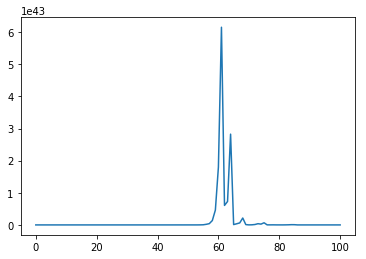

In [26]:
x, trajectory = gd.gd(lambda x: sin(4* x**2) + 2 * x**2 - x, lambda x: cos(4* x**2) * 8 * x + 4 *x - 1, 10, 100, 2)
print(x)
plot(trajectory)
show()

# gets caught in local minima with step size 2

0.0833547930341


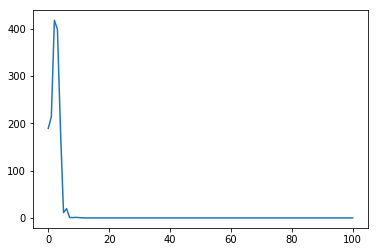

In [27]:
x, trajectory = gd.gd(lambda x: sin(4* x**2) + 2 * x**2 - x, lambda x: cos(4* x**2) * 8 * x + 4 *x - 1, 10, 100, 0.2)
print(x)
plot(trajectory)
show()

# Manages to reach global minima with step size 0.2

[ 0.0036459   0.00182295]


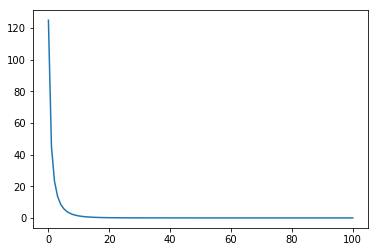

In [28]:
x, trajectory = gd.gd(lambda x: linalg.norm(x)**2, lambda x: 2*x, array([10,5]), 100, 0.2)
print(x)
# array([ 0.0036459 ,  0.00182295])
plot(trajectory)
show()

Our generic linear classifier implementation is
in `linear.py`.  The way this works is as follows.  We have an
interface `LossFunction` that we want to minimize.  This must
be able to compute the loss for a pair `Y` and `Yhat`
where, the former is the truth and the latter are the predictions.  It
must also be able to compute a gradient when additionally given the
data `X`.  This should be all you need for these.

There are three loss function stubs: `SquaredLoss` (which is
implemented for you!), `LogisticLoss` and `HingeLoss`
(both of which you'll have to implement.  My suggestion is to hold off
implementing the other two until you have the linear classifier
working.

The `LinearClassifier` class is a stub implemention of a
generic linear classifier with an l2 regularizer.  It
is *unbiased* so all you have to take care of are the weights.
Your implementation should go in `train`, which has a handful
of stubs.  The idea is to just pass appropriate functions
to `gd` and have it do all the work.  See the comments inline
in the code for more information.
 
Once you've implemented the function evaluation and gradient, we can
test this.  We'll begin with a very simple 2D example data set so that
we can plot the solutions.  We'll also start with *no
regularizer* to help you figure out where errors might be if you
have them.  (You'll have to import `mlGraphics` to make this
work.)

Training accuracy 0.91, test accuracy 0.86
w=array([ 2.73466371, -0.29563932])


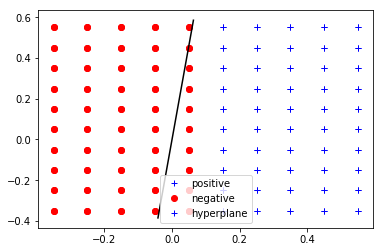

In [29]:
import importlib
importlib.reload(linear)
importlib.reload(gd)

f = linear.LinearClassifier({'lossFunction': linear.SquaredLoss(), 'lambda': 0, 'numIter': 100, 'stepSize': 0.5})
runClassifier.trainTestSet(f, datasets.TwoDAxisAligned)
# Training accuracy 0.91, test accuracy 0.86
print(f)
# w=array([ 2.73466371, -0.29563932])
mlGraphics.plotLinearClassifier(f, datasets.TwoDAxisAligned.X, datasets.TwoDAxisAligned.Y)
show(False)

Note that even though this data is clearly linearly separable,
the *unbiased* classifier is unable to perfectly separate it.

If we change the regularizer, we'll get a slightly different
solution:

In [30]:
f = linear.LinearClassifier({'lossFunction': linear.SquaredLoss(), 'lambda': 10, 'numIter': 100, 'stepSize': 0.5})
runClassifier.trainTestSet(f, datasets.TwoDAxisAligned)
# Training accuracy 0.9, test accuracy 0.86
print(f)
# w=array([ 1.30221546, -0.06764756])

Training accuracy 0.9, test accuracy 0.86
w=array([ 1.30221546, -0.06764756])


As expected, the weights are *smaller*.

Now, we can try different loss functions.  Implement logistic loss and
hinge loss.  Here are some simple test cases:

In [4]:
import importlib
importlib.reload(linear)

f = linear.LinearClassifier({'lossFunction': linear.LogisticLoss(), 'lambda': 10, 'numIter': 100, 'stepSize': 0.5})
runClassifier.trainTestSet(f, datasets.TwoDDiagonal)
# Training accuracy 0.99, test accuracy 0.86
print(f)
# w=array([ 0.29809083,  1.01287561])

Training accuracy 0.99, test accuracy 0.86
w=array([ 0.29809083,  1.01287561])


C:\Mayuri_local\UIC\2018_Spring\IML\IML_HW3\hw3\linear.py:67: RuntimeWarning: overflow encountered in exp
  return sum(log(1 + exp(-dot(Y, Yhat))))


In [32]:
import importlib
importlib.reload(linear)

f = linear.LinearClassifier({'lossFunction': linear.HingeLoss(), 'lambda': 1, 'numIter': 100, 'stepSize': 0.5})
runClassifier.trainTestSet(f, datasets.TwoDDiagonal)
# Training accuracy 0.98, test accuracy 0.86
print(f)
# w=array([ 1.17110065,  4.67288657])

Training accuracy 0.98, test accuracy 0.86
w=array([ 1.17110065,  4.67288657])


<img src="data/kitten.jpeg" width="100px" align="left" float="left"/>
<br><br><br>
## WU5 (5%):
For each of the loss functions, train a model on the
binary version of the wine data (called WineDataBinary) and evaluate
it on the test data. You should use lambda=1 in all cases. Which works
best? For that best model, look at the learned weights. Find
the *words* corresponding to the weights with the greatest
positive value and those with the greatest negative value (this is
like LAB3). Hint: look at WineDataBinary.words to get the id-to-word
mapping. List the top 5 positive and top 5 negative and explain.

[Your WU5 answer here]
On training model on the binary version of the wine data using SquaredLoss, LogisticLoss and HingeLoss functions, we can see that LogisticLoss function works best. 
Training and test accuracy for all three functions are as below:

SquaredLoss:
Training accuracy 0.242914979757085, test accuracy 0.31365313653136534

LogisticLoss:
Training accuracy 0.9959514170040485, test accuracy 0.974169741697417

HingeLoss:
Training accuracy 0.9959514170040485, test accuracy 0.9520295202952029

Top positive and top negative weights and words corresponding to those for the best model(using LogisticLoss in this case):

top_positive_w:  [ 80  84 130 135 351]
top_negative_w:  [ 21  10   2  88 114]
top_positive_weights_words:  ['tropical', 'acidity', 'lime', 'crisp', 'citrus']
top_negative_weights_words:  ['tannins', 'black', 'dark', 'cherry', 'blackberry']

In [160]:
import importlib
importlib.reload(linear)

print("")
print("Training model on the binary version of the wine data using SquaredLoss function ")
print("")
f = linear.LinearClassifier({'lossFunction': linear.SquaredLoss(), 'lambda': 1, 'numIter': 100, 'stepSize': 0.5})
runClassifier.trainTestSet(f, datasets.WineDataBinary)
print(f)

print("")
print("Training model on the binary version of the wine data using LogisticLoss function ")
print("")
f = linear.LinearClassifier({'lossFunction': linear.LogisticLoss(), 'lambda': 1, 'numIter': 100, 'stepSize': 0.5})
runClassifier.trainTestSet(f, datasets.WineDataBinary)
print(f)


print("")
print("Training model on the binary version of the wine data using HingeLoss function ")
print("")
f = linear.LinearClassifier({'lossFunction': linear.HingeLoss(), 'lambda': 1, 'numIter': 100, 'stepSize': 0.5})
runClassifier.trainTestSet(f, datasets.WineDataBinary)
print(f)




Training model on the binary version of the wine data using SquaredLoss function 

Training accuracy 0.242914979757085, test accuracy 0.31365313653136534
w=array([  1.51368853e+213,   6.09268891e+213,   3.21507475e+213,
         3.16553665e+212,   1.25506088e+213,   3.04907925e+212,
         3.17890462e+213,   7.39235111e+212,   1.64690181e+213,
         5.76530765e+213,   4.69717950e+213,   1.18776512e+213,
         1.06912711e+213,   2.19280051e+213,   2.96145823e+212,
         2.26609195e+213,   1.96344768e+212,   5.33402757e+213,
         3.50341430e+213,   1.05124361e+213,   7.75154964e+212,
         5.43561659e+213,   7.63175716e+213,   6.78868801e+212,
         5.88615607e+212,   8.15251160e+213,   7.25647780e+213,
         1.57985718e+213,   5.86471628e+213,   1.01752257e+213,
         4.13412669e+212,   9.47652114e+212,   3.09401465e+213,
         4.65762666e+213,   6.45655930e+213,   1.20015388e+213,
         6.39828798e+213,   4.02110473e+212,   7.73754483e+212,
         7.

Training accuracy 0.9959514170040485, test accuracy 0.974169741697417
w=array([ -1.98266249e-01,   1.31616904e-01,  -6.84741830e-01,
         1.00691389e-02,   1.78779194e-02,  -3.05188612e-02,
        -1.89976924e-02,   9.00183167e-02,  -3.39901236e-02,
        -3.33016936e-01,  -7.72612095e-01,  -2.26272888e-01,
        -1.27385579e-02,  -1.34272230e-01,  -3.19749239e-02,
        -3.01115740e-01,  -2.89261751e-02,   2.26508880e-01,
         9.46066625e-02,  -6.30563105e-02,  -1.79127039e-01,
        -1.17217518e+00,   1.34817537e-01,  -2.17478723e-01,
        -9.71414088e-02,  -1.61448810e-01,  -2.63977047e-01,
        -3.96837791e-01,  -1.10080950e-01,  -1.15079371e-01,
         4.00516151e-03,  -1.01758948e-01,  -2.10447399e-01,
        -1.17453720e-01,  -3.80541147e-02,   1.30637262e-01,
        -1.73913057e-01,  -1.30428096e-01,  -1.34036968e-01,
        -1.11851824e-01,  -1.20101346e-01,  -1.20086805e-01,
        -8.69852461e-02,   1.95872206e-01,   6.14042701e-02,
        -2.69

Training accuracy 0.9959514170040485, test accuracy 0.9520295202952029
w=array([ -8.30616352e-01,   4.39266225e-01,  -3.13353046e+00,
         5.16897984e-02,  -3.90305469e-01,  -2.35818203e-01,
        -3.54319104e-01,   2.91446765e-01,  -3.86189315e-01,
        -1.44488979e+00,  -4.24458751e+00,  -1.07971853e+00,
        -6.94578681e-02,  -1.88233920e-01,  -2.35818203e-01,
        -1.50759492e+00,  -1.83607770e-01,   5.69969012e-01,
         7.09368848e-01,  -3.44842555e-01,  -4.90850964e-01,
        -5.04590808e+00,  -1.61236312e-01,  -5.95974009e-01,
        -6.08081288e-01,  -1.41005726e+00,  -1.06361816e+00,
        -1.53245188e+00,  -4.94102492e-01,  -6.01261309e-01,
        -8.75070519e-02,  -6.00312008e-01,  -1.26611658e+00,
        -3.17096435e-01,  -3.03633259e-01,   4.34795986e-01,
        -9.75195645e-01,  -2.28284267e-01,  -5.14158268e-01,
        -6.13127997e-01,  -4.67187562e-01,  -4.94649690e-01,
        -2.35818203e-01,   1.61766189e+00,   4.43343485e-01,
        -4.7

In [161]:
import importlib
importlib.reload(linear)

f = linear.LinearClassifier({'lossFunction': linear.LogisticLoss(), 'lambda': 1, 'numIter': 100, 'stepSize': 0.5})
runClassifier.trainTestSet(f, datasets.WineDataBinary)
print(f)

weights = f.getRepresentation()
print("***********************************")
#print(weights)

sorted_weights = argsort(weights)
#print("sorted_weights.shape: ",sorted_weights.shape)
top_positive_w = sorted_weights[-5:]
print("top_positive_w: ",top_positive_w)
#print("top_positive_w shape: ",top_positive_w.shape)

top_negative_w = sorted_weights[:5]
print("top_negative_w: ",top_negative_w)
#print("top_negative_w shape: ",top_negative_w.shape)

top_positive_weights_words = [datasets.WineDataBinary.words[i] for i in top_positive_w]
print("top_positive_weights_words: ",top_positive_weights_words)

top_negative_weights_words = [datasets.WineDataBinary.words[i] for i in top_negative_w]
print("top_negative_weights_words: ",top_negative_weights_words)

Training accuracy 0.9959514170040485, test accuracy 0.974169741697417
w=array([ -1.98266249e-01,   1.31616904e-01,  -6.84741830e-01,
         1.00691389e-02,   1.78779194e-02,  -3.05188612e-02,
        -1.89976924e-02,   9.00183167e-02,  -3.39901236e-02,
        -3.33016936e-01,  -7.72612095e-01,  -2.26272888e-01,
        -1.27385579e-02,  -1.34272230e-01,  -3.19749239e-02,
        -3.01115740e-01,  -2.89261751e-02,   2.26508880e-01,
         9.46066625e-02,  -6.30563105e-02,  -1.79127039e-01,
        -1.17217518e+00,   1.34817537e-01,  -2.17478723e-01,
        -9.71414088e-02,  -1.61448810e-01,  -2.63977047e-01,
        -3.96837791e-01,  -1.10080950e-01,  -1.15079371e-01,
         4.00516151e-03,  -1.01758948e-01,  -2.10447399e-01,
        -1.17453720e-01,  -3.80541147e-02,   1.30637262e-01,
        -1.73913057e-01,  -1.30428096e-01,  -1.34036968e-01,
        -1.11851824e-01,  -1.20101346e-01,  -1.20086805e-01,
        -8.69852461e-02,   1.95872206e-01,   6.14042701e-02,
        -2.69

# Part 3: Classification with Many Classes *[0% -- up to 15% extra credit]*

Finally, we'll do multiclass classification using Scikit-learn functionality. You can find the documentation here: http://scikit-learn.org/stable/modules/multiclass.html.

Quiz bowl is a game in which two teams compete head-to-head to answer questions from different areas of knowledge. It lets players interrupt the reading of a question when they know the answer. The goal here is to see how well a classifier performs in predicting the `Answer` of a question when a different portion of the question is revealed.

Here's an example question from the development data:

    206824,dev,History,Alan Turing,"This man and Donald Bayley created a secure voice communications machine called ""Delilah"". ||| The Chinese Room Experiment was developed by John Searle in response to one of this man's namesake tests. ||| He showed that the halting problem was undecidable. ||| He devised a bombe with Gordon Welchman that found the settings of an Enigma machine. ||| One of this man's eponymous machines which can perform any computing task is his namesake ""complete."" Name this man, whose eponymous test is used to determine if a machine can exhibit behavior indistinguishable from that of a human." 

The more of the question you get, the easier the problem becomes.

The default code below just runs OVA and AVA on top of a linear SVM (it might take a few seconds):

In [139]:
import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from numpy import *
import datasets
import importlib

importlib.reload(datasets)

if not datasets.Quizbowl.loaded:
    datasets.loadQuizbowl()

print('\n\nRUNNING ON EASY DATA\n')
    
print('training ova')
X = datasets.QuizbowlSmall.X
Y = datasets.QuizbowlSmall.Y
ova = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X, Y)
print('predicting ova')
ovaDevPred = ova.predict(datasets.QuizbowlSmall.Xde)
print('error = {0}'.format(mean(ovaDevPred != datasets.QuizbowlSmall.Yde)))

print('training ava')
ava = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X, Y)
print('predicting ava')
avaDevPred = ava.predict(datasets.QuizbowlSmall.Xde)
print('error = {0}'.format(mean(avaDevPred != datasets.QuizbowlSmall.Yde)))

print('\n\nRUNNING ON HARD DATA\n')
    
print('training ova')
X = datasets.QuizbowlHardSmall.X
Y = datasets.QuizbowlHardSmall.Y
ova = OneVsOneClassifier(LinearSVC(random_state=0)).fit(X, Y)
print('predicting ova')
ovaDevPred = ova.predict(datasets.QuizbowlHardSmall.Xde)
print('error = {0}'.format(mean(ovaDevPred != datasets.QuizbowlHardSmall.Yde)))

print('training ava')
ava = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X, Y)
print('predicting ava')
avaDevPred = ava.predict(datasets.QuizbowlHardSmall.Xde)
print('error = {0}'.format(mean(avaDevPred != datasets.QuizbowlHardSmall.Yde)))

savetxt('predictions.txt', avaDevPred)

Loading Quizbowl dataset...

total labels: 2370
unique features: 8416
total training examples: 8845


Loading QuizbowlSmall dataset...

total labels: 31
unique features: 8416
total training examples: 361


Loading QuizbowlHard dataset...

total labels: 2370
unique features: 4132
total training examples: 8845


Loading QuizbowlHardSmall dataset...

total labels: 31
unique features: 4132
total training examples: 361


RUNNING ON EASY DATA

training ova
predicting ova
error = 0.2934131736526946
training ava
predicting ava
error = 0.218562874251497


RUNNING ON HARD DATA

training ova
predicting ova
error = 0.5958083832335329
training ava
predicting ava
error = 0.5538922155688623


In [142]:
#Testing error with different scikit-learn binary classifiers for both OVA and AVA on easy dataset.

import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from numpy import *
import datasets
import importlib
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

importlib.reload(datasets)

if not datasets.Quizbowl.loaded:
    datasets.loadQuizbowl()

print('\n\nRUNNING ON EASY DATA\n')

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]       

X = datasets.QuizbowlSmall.X
Y = datasets.QuizbowlSmall.Y

for i, cls in enumerate(classifiers):

    print('training ova using classifier:',i)
    ova = OneVsOneClassifier(cls).fit(X, Y)
    print('predicting ova using classifier:',i)
    ovaDevPred = ova.predict(datasets.QuizbowlSmall.Xde)
    print('error = {0}'.format(mean(ovaDevPred != datasets.QuizbowlSmall.Yde)))

    print('training ava using classifier:',i)
    ava = OneVsRestClassifier(cls).fit(X, Y)
    print('predicting ava using classifier:',i)
    avaDevPred = ava.predict(datasets.QuizbowlSmall.Xde)
    print('error = {0}'.format(mean(avaDevPred != datasets.QuizbowlSmall.Yde)))

#savetxt('predictions.txt', avaDevPred)



Loading Quizbowl dataset...

total labels: 2370
unique features: 8416
total training examples: 8845


Loading QuizbowlSmall dataset...

total labels: 31
unique features: 8416
total training examples: 361


Loading QuizbowlHard dataset...

total labels: 2370
unique features: 4132
total training examples: 8845


Loading QuizbowlHardSmall dataset...

total labels: 31
unique features: 4132
total training examples: 361


RUNNING ON EASY DATA

training ova using classifier: 0
predicting ova using classifier: 0
error = 0.47604790419161674
training ava using classifier: 0
predicting ava using classifier: 0
error = 0.5
training ova using classifier: 1
predicting ova using classifier: 1
error = 0.32934131736526945
training ava using classifier: 1
predicting ava using classifier: 1
error = 0.23652694610778444
training ova using classifier: 2
predicting ova using classifier: 2
error = 0.9670658682634731
training ava using classifier: 2
predicting ava using classifier: 2
error = 0.9610778443113772
training ova using classifier: 3
predicting ova using classifier: 3
error = 0.4341317365269461
training ava using classifier: 3
predicting ava using classifier: 3
error = 0.3263473053892216
training ova using classifier: 4
predicting ova using classifier: 4
error = 0.4221556886227545
training ava using classifier: 4
predicting ava using classifier:

C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

predicting ova using classifier: 9
error = 0.9311377245508982
training ava using classifier: 9


C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\mayur\Anaconda3\lib\site-

predicting ava using classifier: 9
error = 0.9491017964071856


In [2]:
# Using MLPClassifier in OneVsRestClassifier for training on dev data which gives least error 
# as compared to others as found in above testing.

import sklearn.metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from numpy import *
import datasets
import importlib
importlib.reload(datasets)
from sklearn.neural_network import MLPClassifier

if not datasets.Quizbowl.loaded:
    datasets.loadQuizbowl()

print('\n\nRUNNING ON SMALL DATA\n')
    
print('training ava')
X = datasets.QuizbowlSmall.X
Y = datasets.QuizbowlSmall.Y
ava = OneVsRestClassifier(MLPClassifier(alpha=1)).fit(X, Y)
print('predicting ava')
avaDevPred = ava.predict(datasets.QuizbowlSmall.Xde)
print('error = {0}'.format(mean(avaDevPred != datasets.QuizbowlSmall.Yde)))

savetxt('predictions.txt', avaDevPred)

Loading Quizbowl dataset...

total labels: 2370
unique features: 8416
total training examples: 8845


Loading QuizbowlSmall dataset...

total labels: 31
unique features: 8416
total training examples: 361


Loading QuizbowlHard dataset...

total labels: 2370
unique features: 4132
total training examples: 8845


Loading QuizbowlHardSmall dataset...

total labels: 31
unique features: 4132
total training examples: 361


RUNNING ON SMALL DATA

training ava
predicting ava
error = 0.19760479041916168


When you run the code above, you should see some statistics of the loaded datasets and the following error rates on two of the datasets `QuizbowlSmall` and `QuizbowlHardSmall` using OVA and AVA:

```
RUNNING ON EASY DATA

training ova
predicting ova
error = 0.293413
training ava
predicting ava
error = 0.218563


RUNNING ON HARD DATA

training ova
predicting ova
error = 0.595808
training ava
predicting ava
error = 0.553892
```

This is running on a shrunken version of the data (that only contains answers that occur at least 20 times in the data).

The first ("easy") version is when you get to see the entire question. The second ("hard") version is when you only get to use the first two sentences. It's clearly significantly harder to answer!

Your task is to achieve the lowest possible error on the development set for `QuizbowlSmall` and `QuizbowlHardSmall`. You will get 5% extra credit for getting lower error (by at least absolute 1%) on *either* dataset than the errors presented above (21.86% for `QuizbowlSmall` and 55.39% for `QuizbowlHardSmall`). 

You're free to use the training data in any way you want, but you must include your code in `quizbowl.py`, submit your predictions file(s), and a writeup here that says what you did, in order to receive the extra credit. The script `quizbowl.py` includes a command in the last line that saves predictions to a text file `predictions.txt`. You need to edit this line to rename the file to either `predictionsQuizbowlSmall.txt` or `predictionsQuizbowlHardSmall.txt` dependent on the dataset: that's what you upload for the EC. 

## WU-EC2 (5%):

[YOUR WU-EC2 WRITEUP HERE] :

To reduce the error for the above quizbowl problem, I tried with different scikit learn classifiers mentioned below as binary classifier for OVA and AVA. I used these classifiers as list, iterated it one by one and used is as binary classifier and noted their errors. With this experiment, I found that MLPClassifier does pretty well on easy data and I got the error reduced by more than 1 % with this classifier.

classifiers used to check error = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=10),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()] 
    
Best classifier found with OneVsRestClassifier: MLPClassifier

Below is the error that I got when used MLPClassifier in OneVsRestClassifier

RUNNING ON SMALL DATA

training ava
predicting ava
error = 0.19760479041916168

Error with above model is less than 1% as compared to error found with LinearSVC classifier used earlier.

Additionally, you can get extra credit for providing the lowest-error solution on the full versions of the easy and hard problems, `Quizbowl` and `QuizbowlHard` in comparison to your classmates' solutions. There will be two separate (hidden) leaderboards for each of these two datasets. You will receive 5% if your solution is the best for the respective dataset (first place), 3% for second place and 1% for third. We will reveal the top three scores for each dataset after the submission period is over, and you are welcome to compete in both. Note that this problem is much harder due to the larger number of class labels. A simple majority label classifier has an error of 99.89%.

You're free to use the training data in any way you want, but you must include your code in `quizbowl.py`, submit your predictions file(s) (`predictionsQuizbowl.txt` and/or `predictionsQuizbowlHard.txt`), and a writeup here that says what you did, in order to receive the extra credit.

<img src="data/kitten.jpeg" width="100px" align="left" float="left"/>
<br><br><br>
## WU-EC3 (up to 10%):

[YOUR WU-EC3 WRITEUP HERE] 